In [1]:
import numpy as np
import sys
#sys.path.append('mean_field_adapt')
#from transfer_functions.tf_simulation import single_experiment_2,single_experiment
from transfer_functions.load_config import load_transfer_functions,load_transfer_functions_with_ALL_params
from scipy.integrate import odeint
from single_cell_models.cell_library import get_neuron_params
from synapses_and_connectivity.syn_and_connec_library import get_connectivity_and_synapses_matrix
from transfer_functions.tf_simulation import reformat_syn_parameters
import matplotlib.pylab as plt

from scipy.optimize import fsolve
from scipy.optimize import minimize
import math

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
cd ../

/media/mcarlu/DATA/NEURO/SEPTEMBER2020


In [4]:
from MF_functions_clean import *

In [5]:
cd mean_field_adapt/

/media/mcarlu/DATA/NEURO/SEPTEMBER2020/mean_field_adapt


## First, build the new code


In [6]:
h=0.0001
T=0.005
Ntot=10000

number_of_populations=2 
number_of_adaptive=1

p_con=np.ones((2,2))*(0.05)
delays=np.zeros((2,2))*(0.05)
#p_con[2][2]=0.6
#p_con[1][2]=p_con[2][1]=0 ## the two FS populations are not connected !
p_pois=np.ones(2)*0.05

''' Now params becomes a dictionary'''

#numb_par=28
params={}

params['diff']=[0,0] # by default nothing changes from neuron model
params['tstep']=5e-4 
params['numb_var']=number_of_populations**2+number_of_populations+number_of_adaptive#14 # total numb of var 
params['tauw']=[1,0] # tau_w
params['a']=[0,0] # a
params['b']=[60e-12,0] # b
params['El']=[-70e-3,0] # El
params['total_size']=10000
params['size_subpop']=[8000,2000] 
params['numb_pop']=number_of_populations
params['numb_adapt']=number_of_adaptive
params['tau_e']=5e-3 # Tau_e
params['tau_i']=5e-3 # Tau_i
params['qe']=1.5e-9 # Qe
params['qi']=5e-9 # Qi
params['Ee']=0 # Ee
params['Ei']=-80e-3 # Ei
params['Gl']=[10e-9,10e-9]
params['Vthre']=[-50e-3,-50e-3]
params['Cm']=[200e-12,200e-12]

params['delays']=delays



params['h']=h
params['T']=T
params['mu']=mu_V_dN_dp

params['ext_inp']=[2.5,2.5]
params['inp_funct']=0 # input function
params['inp_par']=0 # input parameters
params['numb_sub_exc']=1# numb_sub_exc
params['numb_sub_inh']=1# numb_sub_inh
params['p_conn']=p_con # not anymore dp, here it is plain p 
params['p_pois']=p_pois



print(params)

{'diff': [0, 0], 'tstep': 0.0005, 'numb_var': 7, 'tauw': [1, 0], 'a': [0, 0], 'b': [6e-11, 0], 'El': [-0.07, 0], 'total_size': 10000, 'size_subpop': [8000, 2000], 'numb_pop': 2, 'numb_adapt': 1, 'tau_e': 0.005, 'tau_i': 0.005, 'qe': 1.5e-09, 'qi': 5e-09, 'Ee': 0, 'Ei': -0.08, 'Gl': [1e-08, 1e-08], 'Vthre': [-0.05, -0.05], 'Cm': [2e-10, 2e-10], 'delays': array([[0., 0.],
       [0., 0.]]), 'h': 0.0001, 'T': 0.005, 'mu': <function mu_V_dN_dp at 0x7f428b977a60>, 'ext_inp': [2.5, 2.5], 'inp_funct': 0, 'inp_par': 0, 'numb_sub_exc': 1, 'numb_sub_inh': 1, 'p_conn': array([[0.05, 0.05],
       [0.05, 0.05]]), 'p_pois': array([0.05, 0.05])}


In [7]:
# Run the MF without adaptation a = b = 0 
#sys.path.append('../')

NTWK='CONFIG1'


NRN1='RS-cell'
NRN2='FS-cell'


TF_temp = load_transfer_functions_with_ALL_params(NRN1, NRN2, NTWK,params)
#TF_temp2 = load_transfer_functions(NRN3, NRN3, NTWK) # lazy to rewrite a load_TF function

TF=(TF_temp[0],TF_temp[1]) # TF defined as a tuple

params['TF']=TF


### Integrate the MF equations

In [8]:
np.random.seed(10)
#x0=np.random.rand(7)*1e-5
#x0=np.ones(7)*1e-5
#x0=np.random.rand(7)*1e-5
x0=np.ones(7)*1e-2
x0[0]=0.6 
x0[1]=7.0
x0[6]=x0[0]*60e-12
print(x0)
time=0
t_trace=[]
#x_trace_aWITHTAU=[]
x_trace_RS=[]
TF_trace_RS=[]
Dissip_tt=[]
Dissip_all_2pop=[]
Dissip_delta_2pop=[]
Dissip_w_2pop=[]

x_trace_RS.append(x0.copy())
#x_trace_RS.append(x0.copy())

##################### INITIATE THE PAST COORDINANTES ##########################

delay_matrix=np.matrix(delays)
max_delay=delay_matrix.max()

#### Associated number of time steps ####

steps=int(max_delay/params['tstep'])

for i in range(steps):x_trace_RS.append(x0.copy())
    
##################################################################################

print(x0)
time=0
    
for i in np.arange(0,5,params['tstep']):
    params['x_hist']=np.transpose(x_trace_RS)
    TF_inst=Euler_method_General(x0,params,time,MeanField_dN_dp_delay)
    if (i%0.5==0):print('i = ', i, '\n')
    time+=params['tstep']
    t_trace.append(time)
    #Dissip_tt.append(MF_dissip_FO(x0,time,params))
    #Dissip_all_2pop.append(MF_dissip_FO(x0,time,params)[0])
    #Dissip_delta_2pop.append(MF_dissip_FO(x0,time,params)[1])
    #Dissip_w_2pop.append(MF_dissip_FO(x0,time,params)[2])
    x_trace_RS.append(x0.copy())
    TF_trace_RS.append(TF_inst.copy())
    #TF_trace_3pop_Eduarda_5.append((params[9][0]((x0[0]+x0[1])/2+params[21],x0[2],x0[12]),\
                     #params[9][1]((x0[0]+x0[1])/2+params[21],x0[2],x0[13]),\
                     #params[9][2]((x0[0]+x0[1])/2+params[21],x0[2],0)))

[6.0e-01 7.0e+00 1.0e-02 1.0e-02 1.0e-02 1.0e-02 3.6e-11]
[6.0e-01 7.0e+00 1.0e-02 1.0e-02 1.0e-02 1.0e-02 3.6e-11]
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 

i =  2.0 

i =  2.5 

i =  3.0 

i =  3.5 

i =  4.0 

i =  4.5 



In [9]:
final_state=x_trace_RS[-1]
print(final_state)

[9.21837937e-01 7.83625329e+00 5.33841222e-02 1.04640336e-01
 1.04640336e-01 3.14871127e-01 5.53101688e-11]


In [10]:
x_transp=np.transpose(x_trace_RS)
TF_transp=np.transpose(TF_trace_RS)
#inp_rate=np.transpose(inp_trace)

ve=x_transp[0]#[1000:] # remove first 10000 elements
vi=x_transp[1]#[1000:]
cee=x_transp[2]#[1000:]
cei=x_transp[3]#[1000:]
cie=x_transp[4]#[1000:]
cii=x_transp[5]#[1000:]
w=x_transp[6]

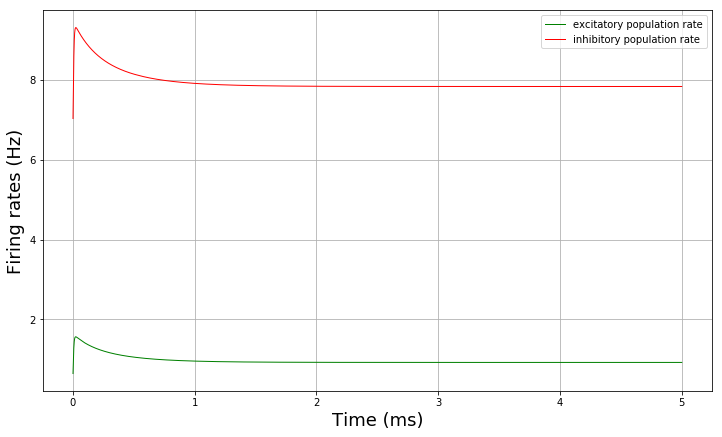

In [11]:
fig,ax=plt.subplots(figsize=(12, 7))

ax.plot(t_trace,ve[1:],color="green",lw="1",label="excitatory population rate")
ax.plot(t_trace,vi[1:],color="red",lw="1",label="inhibitory population rate")
#ax.plot(t[100:]*1000, state_2[100:, 0], color="green",lw="2", ls="--")
#ax.plot(t[100:]*1000, state_2[100:, 1], color="red", lw="2",ls="--")

#ax.plot(t, state_2[:, 2], color="blue", label="excitory cee")
#ax.plot(t, state_2[:, 3], color="purple", label="inhibitory cii")
#ax.plot(t, state_2[:, 4], color="yellow", label="cei")
#ax.plot(t, state_2[:, 5], color="orange", label="cei")
#ax.plot(t,test_input, color="black", linestyle=":", label="forcing")



ax.set_xlabel("Time (ms)",fontsize=18)
ax.grid(True)
ax.set_ylabel("Firing rates (Hz)",fontsize=18)
ax.legend()
#ax.title("Mean-Field Dynamics")

#ax.show()

### Now let's use some delay !

In [12]:
delays=np.zeros((2,2))
delays[0][1]=delays[1][0]=0.005


In [13]:
np.random.seed(10)
#x0=np.random.rand(7)*1e-5
#x0=np.ones(7)*1e-5
#x0=np.random.rand(7)*1e-5
x0=final_state.copy()
x0[0]+=0.5
print(x0)
time=0
t_trace=[]
#x_trace_aWITHTAU=[]
x_trace_RS=[]
TF_trace_RS=[]
Dissip_tt=[]
Dissip_all_2pop=[]
Dissip_delta_2pop=[]
Dissip_w_2pop=[]

x_trace_RS.append(x0.copy())
#x_trace_RS.append(x0.copy())

##################### INITIATE THE PAST COORDINANTES ##########################

delay_matrix=np.matrix(delays)
max_delay=delay_matrix.max()
print('Max delay = ', max_delay)
#### Associated number of time steps ####

steps=int(max_delay/params['tstep'])

for i in range(steps):x_trace_RS.append(x0.copy())
    
##################################################################################

print(x0)
time=0
    
for i in np.arange(0,5,params['tstep']):
    params['x_hist']=np.transpose(x_trace_RS)
    TF_inst=Euler_method_General(x0,params,time,MeanField_dN_dp_delay)
    if (i%0.5==0):print('i = ', i, '\n')
    time+=params['tstep']
    t_trace.append(time)
    #Dissip_tt.append(MF_dissip_FO(x0,time,params))
    #Dissip_all_2pop.append(MF_dissip_FO(x0,time,params)[0])
    #Dissip_delta_2pop.append(MF_dissip_FO(x0,time,params)[1])
    #Dissip_w_2pop.append(MF_dissip_FO(x0,time,params)[2])
    x_trace_RS.append(x0.copy())
    TF_trace_RS.append(TF_inst.copy())
    #TF_trace_3pop_Eduarda_5.append((params[9][0]((x0[0]+x0[1])/2+params[21],x0[2],x0[12]),\
                     #params[9][1]((x0[0]+x0[1])/2+params[21],x0[2],x0[13]),\
                     #params[9][2]((x0[0]+x0[1])/2+params[21],x0[2],0)))

[1.42183794e+00 7.83625329e+00 5.33841222e-02 1.04640336e-01
 1.04640336e-01 3.14871127e-01 5.53101688e-11]
Max delay =  0.005
[1.42183794e+00 7.83625329e+00 5.33841222e-02 1.04640336e-01
 1.04640336e-01 3.14871127e-01 5.53101688e-11]
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 

i =  2.0 

i =  2.5 

i =  3.0 

i =  3.5 

i =  4.0 

i =  4.5 



In [14]:
x_transp=np.transpose(x_trace_RS)
TF_transp=np.transpose(TF_trace_RS)
#inp_rate=np.transpose(inp_trace)

ve=x_transp[0]#[1000:] # remove first 10000 elements
vi=x_transp[1]#[1000:]
cee=x_transp[2]#[1000:]
cei=x_transp[3]#[1000:]
cie=x_transp[4]#[1000:]
cii=x_transp[5]#[1000:]
w=x_transp[6]

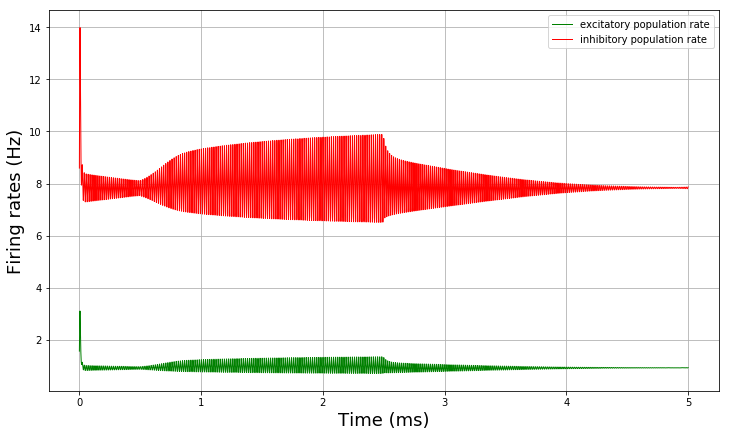

In [18]:
fig,ax=plt.subplots(figsize=(12, 7))

ax.plot(t_trace,ve[steps+1:],color="green",lw="1",label="excitatory population rate")
ax.plot(t_trace,vi[steps+1:],color="red",lw="1",label="inhibitory population rate")
#ax.plot(t[100:]*1000, state_2[100:, 0], color="green",lw="2", ls="--")
#ax.plot(t[100:]*1000, state_2[100:, 1], color="red", lw="2",ls="--")

#ax.plot(t, state_2[:, 2], color="blue", label="excitory cee")
#ax.plot(t, state_2[:, 3], color="purple", label="inhibitory cii")
#ax.plot(t, state_2[:, 4], color="yellow", label="cei")
#ax.plot(t, state_2[:, 5], color="orange", label="cei")
#ax.plot(t,test_input, color="black", linestyle=":", label="forcing")



ax.set_xlabel("Time (ms)",fontsize=18)
ax.grid(True)
ax.set_ylabel("Firing rates (Hz)",fontsize=18)
ax.legend()
#ax.title("Mean-Field Dynamics")
#ax.set_xlim(2,3)
#ax.show()

### Actual perturbation

In [103]:
AmpStim1=0.5
#Binp=2
def heaviside(x):
    return 0.5 * (1 + np.sign(x))


def input_rate(t, t1_exc, tau1_exc, tau2_exc, ampl_exc):
    # t1_exc=10. # time of the maximum of external stimulation
    # tau1_exc=20. # first time constant of perturbation = rising time
    # tau2_exc=50. # decaying time
    # ampl_exc=20. # amplitude of excitation
    inp = ampl_exc * (np.exp(-(t - t1_exc) ** 2 / (2. * tau1_exc ** 2)) * heaviside(-(t - t1_exc)) + \
                      np.exp(-(t - t1_exc) ** 2 / (2. * tau2_exc ** 2)) * heaviside(t - t1_exc))
    return inp

'''
input_rate=params['inp_funct']

if (input_rate != 0): input_func=input_rate(t, *params['inp_par'])
else : input_func=0

ji, 1000., 10., 400., AmpStim1))
'''

params['inp_funct']=input_rate # input function
params['inp_par']=[1., 0.02, 0.02, AmpStim1] # input parameters

In [104]:
np.random.seed(10)
#x0=np.random.rand(7)*1e-5
#x0=np.ones(7)*1e-5
#x0=np.random.rand(7)*1e-5
x0=final_state.copy()
#x0[0]+=0.5
print(x0)
time=0
t_trace=[]
#x_trace_aWITHTAU=[]
x_trace_RS=[]
TF_trace_RS=[]
Dissip_tt=[]
Dissip_all_2pop=[]
Dissip_delta_2pop=[]
Dissip_w_2pop=[]

x_trace_RS.append(x0.copy())
#x_trace_RS.append(x0.copy())

##################### INITIATE THE PAST COORDINANTES ##########################

delay_matrix=np.matrix(delays)
max_delay=delay_matrix.max()
print('Max delay = ', max_delay)
#### Associated number of time steps ####

steps=int(max_delay/params['tstep'])

for i in range(steps):x_trace_RS.append(x0.copy())
    
##################################################################################

print(x0)
time=0
    
for i in np.arange(0,5,params['tstep']):
    params['x_hist']=np.transpose(x_trace_RS)
    TF_inst=Euler_method_General(x0,params,time,MeanField_dN_dp_delay)
    if (i%0.5==0):print('i = ', i, '\n')
    time+=params['tstep']
    t_trace.append(time)
    #Dissip_tt.append(MF_dissip_FO(x0,time,params))
    #Dissip_all_2pop.append(MF_dissip_FO(x0,time,params)[0])
    #Dissip_delta_2pop.append(MF_dissip_FO(x0,time,params)[1])
    #Dissip_w_2pop.append(MF_dissip_FO(x0,time,params)[2])
    x_trace_RS.append(x0.copy())
    TF_trace_RS.append(TF_inst.copy())
    #TF_trace_3pop_Eduarda_5.append((params[9][0]((x0[0]+x0[1])/2+params[21],x0[2],x0[12]),\
                     #params[9][1]((x0[0]+x0[1])/2+params[21],x0[2],x0[13]),\
                     #params[9][2]((x0[0]+x0[1])/2+params[21],x0[2],0)))

[9.21837937e-01 7.83625329e+00 5.33841222e-02 1.04640336e-01
 1.04640336e-01 3.14871127e-01 5.53101688e-11]
Max delay =  0.005
[9.21837937e-01 7.83625329e+00 5.33841222e-02 1.04640336e-01
 1.04640336e-01 3.14871127e-01 5.53101688e-11]
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 

i =  2.0 

i =  2.5 

i =  3.0 

i =  3.5 

i =  4.0 

i =  4.5 



In [105]:
x_transp=np.transpose(x_trace_RS)
TF_transp=np.transpose(TF_trace_RS)
#inp_rate=np.transpose(inp_trace)

ve=x_transp[0]#[1000:] # remove first 10000 elements
vi=x_transp[1]#[1000:]
cee=x_transp[2]#[1000:]
cei=x_transp[3]#[1000:]
cie=x_transp[4]#[1000:]
cii=x_transp[5]#[1000:]
w=x_transp[6]

(2, 3)

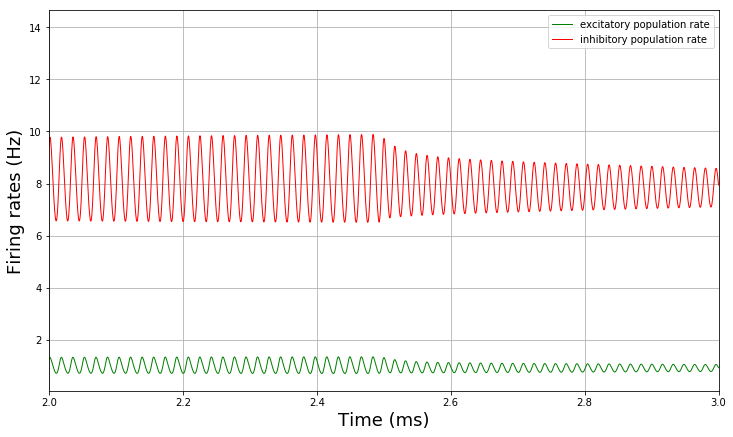

In [19]:
fig,ax=plt.subplots(figsize=(12, 7))

ax.plot(t_trace,ve[steps+1:],color="green",lw="1",label="excitatory population rate")
ax.plot(t_trace,vi[steps+1:],color="red",lw="1",label="inhibitory population rate")
#ax.plot(t[100:]*1000, state_2[100:, 0], color="green",lw="2", ls="--")
#ax.plot(t[100:]*1000, state_2[100:, 1], color="red", lw="2",ls="--")

#ax.plot(t, state_2[:, 2], color="blue", label="excitory cee")
#ax.plot(t, state_2[:, 3], color="purple", label="inhibitory cii")
#ax.plot(t, state_2[:, 4], color="yellow", label="cei")
#ax.plot(t, state_2[:, 5], color="orange", label="cei")
#ax.plot(t,test_input, color="black", linestyle=":", label="forcing")



ax.set_xlabel("Time (ms)",fontsize=18)
ax.grid(True)
ax.set_ylabel("Firing rates (Hz)",fontsize=18)
ax.legend()
#ax.title("Mean-Field Dynamics")
ax.set_xlim(2,3)
#ax.show()